# Mutual Information (MI) for Utility Factor
Implemented Mutual Information as a metric for Utility Factor.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import matplotlib.colors as colors
import klcalculator
from random import choices
import os

from math import sqrt
from functools import reduce


In [2]:
os.listdir()

['Datasets.zip',
 'Inmate_Admissions_Numeric.csv',
 '.DS_Store',
 'Inmate_Admissions Data Dictionary.xlsx',
 'vae_mlp',
 'klcalculator.py',
 'Untitled.ipynb',
 'vae_traj.h5',
 'Week2.pptx',
 'Datasets',
 'ACS Artificial Intelligence Starter Guide.pdf',
 'Synthetic_PMES_data.csv',
 'generalized_MI.ipynb',
 '__pycache__',
 'Week3.pptx',
 '16-0026_DATA61_REPORT_TomorrowsDigiallyEnabledWorkforce_WEB_160128.pdf',
 'Offence Charge Code Lookup.xlsx',
 'Inmate_Admissions.csv',
 'DirectedIdeation_20190708123418.ipynb',
 'ACS_Data-Sharing-Frameworks_FINAL_FA_SINGLE_LR.pdf',
 'directed',
 'Inmate_Admissions_sample.csv',
 'AFR-jobs-of-the-future-5JUN2018.pdf',
 'RecurrentVariationalAutoencoder.ipynb',
 '.ipynb_checkpoints',
 'MutualInformation.ipynb',
 'ACS Data Sharing Taskforce - Directed Ideation Report - 26th March 2019_v1.1.pdf',
 'ACS Directed Ideation - Information Evening 1st July 2019_v1_3.pptx']

## Load Data

### Synthetic employee survey

In [3]:
data = pd.read_csv('Synthetic_PMES_data.csv')

In [133]:
def lookup_vals(myval, mydict):
    try:
        return mydict[myval]
    except KeyError:
        return None
    
def create_sparse_dict(df):
    labels = df.value_counts().sort_values()
    lookup_dict = {}
    c = 1 # starting from 1 because we will 0-pad
    for i, v in labels.items():
        lookup_dict[i] = c
        c += 1
    df = pd.DataFrame(df.apply(lookup_vals, args=(lookup_dict,)))
    return df, lookup_dict

def date_to_int(dt):
    return 1000*(dt - datetime.datetime(1970,1,1)).total_seconds()

In [5]:
categorical_cols = [col for col in data.columns if 
                    (data[col].dtype != np.dtype('float64') and data[col].dtype != np.dtype('int64'))]

In [6]:
dicts = []
for col in categorical_cols:
    data[col], my_dict = create_sparse_dict(data[col])
    dicts.append(my_dict)

### Inmates 

In [156]:
data2 = pd.read_csv('Inmate_Admissions.csv')
data2 = data2.fillna(0)

In [158]:
data2.dtypes

Unnamed: 0              int64
INMATEID                int64
ADMITTED_DT           float64
DISCHARGED_DT         float64
RACE                    int64
GENDER                  int64
INMATE_STATUS_CODE      int64
TOP_CHARGE              int64
dtype: object

In [135]:
data2.columns

Index(['Unnamed: 0', 'INMATEID', 'ADMITTED_DT', 'DISCHARGED_DT', 'RACE',
       'GENDER', 'INMATE_STATUS_CODE', 'TOP_CHARGE'],
      dtype='object')

In [136]:
data2.ADMITTED_DT = data2.ADMITTED_DT.astype('datetime64[ns]')
data2.DISCHARGED_DT = data2.DISCHARGED_DT.astype('datetime64[ns]')

data2.RACE, race_dict = create_sparse_dict(data2.RACE)
data2.GENDER, gender_dict = create_sparse_dict(data2.GENDER)
data2.INMATE_STATUS_CODE, status_dict = create_sparse_dict(data2.INMATE_STATUS_CODE)
data2.TOP_CHARGE, charge_dict = create_sparse_dict(data2.TOP_CHARGE)
data2.ADMITTED_DT = data2.ADMITTED_DT.apply(date_to_int)
data2.DISCHARGED_DT = data2.DISCHARGED_DT.apply(date_to_int)

## Multi-column generalization

In [10]:
from collections import Counter
from itertools import combinations
import math
import pandas as pd
from typing import Mapping, Sequence, Any, Tuple, NewType, cast, Optional

distribution = NewType('distribution', Mapping[Any, float])


def get_sample_df() -> pd.DataFrame:
    """
    Define a sample dataframe that we can re-use in docstring tests.
    """
    columns = ['gender', 'age', 'eyes']
    data = [[0, 30, 1], [0, 33, 1], [1, 30, 2], [2, 30, 1], [2, 35, 3], [1, 35, 2], [1, 32, 2], [0, 30, 1]]
    return pd.DataFrame(data, columns=columns)

def get_rounded_df() -> pd.DataFrame:
    columns = ['gender', 'age', 'eyes']
    data = [[0, 30, 1], [0, 35, 1], [1, 30, 2], [1, 30, 1], [1, 35, 2], [1, 35, 2], [1, 30, 2], [0, 30, 1]]
    return pd.DataFrame(data, columns=columns)
    

In [11]:
def calculate_kl(posterior: distribution,
                 prior: distribution,
                 ) -> float:
    """Calculate D_KL(P || Q) (the KL-divergence) in bits.

    D_KL(P || Q) is the `information gained when one revises one's
    beliefs from the prior probability distribution Q to the posterior
    probability distribution P`. (Wikipedia, Kullback-Leibler divergence)

    `p` and `q` are both dictionaries mapping some hashable to a number.
    It is assumed that they are both normalised: their values should add
    up to 0. `q` must not have any 0 values unless the corresponding `p`
    value is also 0.

    >>> calculate_kl(posterior={0: 1, 1: 0}, prior={0: 0.5, 1: 0.5})
    1.0
    >>> calculate_kl(posterior={0: 0.25, 1: 0.75}, prior={0: 0.5, 1: 0.5})
    0.18872187554086717
    """
    return sum(pk * math.log2(pk / prior.get(k, 0))
               for k, pk in posterior.items()
               if pk > 0)

def calculate_distribution_from_values(values: Sequence) -> distribution:
    """
    >>> assert calculate_distribution_from_values([1, 2, 3, 2, 3, 2, 2, 3]) == {1: 0.125, 2: 0.5, 3: 0.375}
    >>> assert calculate_distribution_from_values([(1, 2), (2, 2), (3, 2), (3, 2), (2, 2)]) == \
    {(1, 2): 0.2, (3, 2): 0.4, (2, 2): 0.4}
    """
    counts = Counter(values)
    total_counts = sum(counts.values())
    return cast(distribution, {v: c / total_counts for v, c in counts.items()})

def as_sequence_of_tuples(df: pd.DataFrame) -> Sequence[Tuple]:
    """
    >>> as_sequence_of_tuples(get_sample_df())
    ((0, 30, 1), (0, 35, 1), (1, 30, 2), (1, 30, 1), (1, 35, 2), (1, 35, 2), (1, 30, 2), (0, 30, 1))
    """
    return tuple(tuple(row) for row in df.values)


In [13]:
def calculate_mutual_info(x: pd.Series,
                          y: pd.Series,
                         ) -> float:
    joint_df = pd.DataFrame({'x': x, 'y': y})
    pxy = calculate_distribution_from_values(as_sequence_of_tuples(joint_df))
    px = calculate_distribution_from_values(as_sequence_of_tuples(pd.DataFrame(x)))
    py = calculate_distribution_from_values(as_sequence_of_tuples(pd.DataFrame(y)))
    px_times_py = {(kx[0], ky[0]): x_value * y_value  # Quick and dirty
                   for kx, x_value in px.items()
                   for ky, y_value in py.items()}
    return calculate_kl(prior=px_times_py, posterior=pxy)

In [14]:
x = get_sample_df()['age']
y = get_sample_df()['eyes']
joint_df = pd.DataFrame({'x': x, 'y': y})
pxy = calculate_distribution_from_values(as_sequence_of_tuples(joint_df))
pxy

{(30, 1): 0.375,
 (33, 1): 0.125,
 (30, 2): 0.125,
 (35, 3): 0.125,
 (35, 2): 0.125,
 (32, 2): 0.125}

In [15]:
calculate_mutual_info(x, y)

0.75

In [16]:
px = calculate_distribution_from_values(as_sequence_of_tuples(pd.DataFrame(x)))

In [17]:
py = calculate_distribution_from_values(as_sequence_of_tuples(pd.DataFrame(y)))

In [18]:
{(kx[0], ky[0]): x_value * y_value
               for kx, x_value in px.items()
               for ky, y_value in py.items()}


{(30, 1): 0.25,
 (30, 2): 0.1875,
 (30, 3): 0.0625,
 (33, 1): 0.0625,
 (33, 2): 0.046875,
 (33, 3): 0.015625,
 (35, 1): 0.125,
 (35, 2): 0.09375,
 (35, 3): 0.03125,
 (32, 1): 0.0625,
 (32, 2): 0.046875,
 (32, 3): 0.015625}

In [19]:
calculate_distribution_from_values(as_sequence_of_tuples(pd.DataFrame(pd.DataFrame({'x': x, 'y': y}))))

{(30, 1): 0.375,
 (33, 1): 0.125,
 (30, 2): 0.125,
 (35, 3): 0.125,
 (35, 2): 0.125,
 (32, 2): 0.125}

In [20]:
def calculate_mutual_infos(original_data: pd.DataFrame,
                           modified_data: pd.DataFrame,
                           ) -> np.ndarray:
    """
    >>> calculate_mutual_infos(get_sample_df(), get_rounded_df())
    """
    n = len(original_data.columns)
    assert len(modified_data.columns) == n
    matMI = np.zeros((n, n))
    for ix, ci in enumerate(original_data):
        for jx, cj in enumerate(modified_data):
            matMI[ix, jx] = calculate_mutual_info(original_data[ci], modified_data[cj])
    return matMI

In [169]:
def round_column(df: pd.DataFrame, 
                 col_name: str,
                 base: int ) -> pd.DataFrame:

    def myround(x, base=5):
        try:
            return base * round(x/base)
        except ValueError:
            return np.nan

    rounded_col = [myround(x, base) for x in df[col_name]]
    rounded_df = df.copy()
    rounded_df[col_name] = rounded_col
    
    return rounded_df

def round_column_quartile(df: pd.DataFrame, 
                          col_name: str,
                          buckets: int ) -> pd.DataFrame:

    rounded_col = pd.qcut(df[col_name], buckets, labels=False, duplicates='drop')
    rounded_df = df.copy()
    rounded_df[col_name] = rounded_col
    
    return rounded_df
    

In [22]:
workforceprofile = data[['ATSI_Status', 'Age_Group', 'Current_Role_Years_Employed',
       'Disability_Status', 'Education', 'Employment_Status', 'Gender',
       'Gross_Salary', 'LGBTI_Status']]
workforceprofile = workforceprofile[:1000].fillna(0)

In [23]:
workforceprofile.describe()

,ATSI_Status,Age_Group,Current_Role_Years_Employed,Disability_Status,Education,Employment_Status,Gender,Gross_Salary,LGBTI_Status
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.881000,7.585000,3.87500,2.874000,5.035000,7.170000,2.625000,14.029000,2.834000
std,0.465893,2.691843,1.65835,0.449807,1.937403,1.691733,0.592221,2.067954,0.539198
min,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,6.000000,3.00000,3.000000,4.000000,7.000000,2.000000,14.000000,3.000000
50%,3.000000,8.000000,4.00000,3.000000,6.000000,8.000000,3.000000,15.000000,3.000000
75%,3.000000,10.000000,5.00000,3.000000,7.000000,8.000000,3.000000,15.000000,3.000000
max,3.000000,11.000000,6.00000,3.000000,7.000000,8.000000,3.000000,15.000000,3.000000


In [24]:
workforceprofile.Gross_Salary.unique()

array([14., 15., 13.,  7.,  5., 12., 10.,  6.,  3., 11.,  9.,  8.,  4.,
        2.,  0.])

In [25]:
adjustedworkforceprofile = round_column(workforceprofile, 'Age_Group', 5)
adjustedworkforceprofile = round_column(adjustedworkforceprofile, 'Current_Role_Years_Employed', 2)
adjustedworkforceprofile = round_column(adjustedworkforceprofile, 'Gross_Salary', 2)

## Apply to a real dataset

In [23]:
#%pdb

Automatic pdb calling has been turned ON


In [61]:
a_prime = calculate_mutual_infos(workforceprofile, adjustedworkforceprofile)

In [36]:
a = calculate_mutual_infos(workforceprofile, workforceprofile)

In [26]:
def display_risks(header, risks, rows=20, minr=0, maxr=10):
    """Return an object that prints the attribute-wise risks in Jupyter.

    We colour-code the risks for nice visuals.

    `header` is a list that specifies the table headers.

    `risks` is a list of lists of floats.

    We print at most `rows` (default 20) rows.

    `minr` (default 0) and `maxr` (default 10) specify the cutoff points
    for our colour coding. Anything above `maxr` will be coloured deep
    red for very risky. `minr` is similar.

    The code below is magic and I don't remember how it works.
    """
    df = pd.DataFrame(risks, columns=header)[:rows]
    cm = colors.ListedColormap(
        sns.color_palette("RdYlGn", 256).as_hex()[::-1])
    def risk_to_color(risk):
        color_i = round((min(risk, maxr) - minr) * 255 / (maxr - minr))
        color = cm.colors[color_i]
        return f'background-color: {color}'
    df.index = header
    s = df.style.applymap(risk_to_color)
    return s


In [52]:
display_risks(workforceprofile.columns, a, maxr=1)

,ATSI_Status,Age_Group,Current_Role_Years_Employed,Disability_Status,Education,Employment_Status,Gender,Gross_Salary,LGBTI_Status
0,0.475193,0.0243182,0.0126196,0.00513367,0.0132515,0.0243516,0.00420201,0.0181375,0.00376599
1,0.0243182,3.23841,0.0606135,0.0250806,0.0461547,0.0716802,0.0165523,0.0884149,0.034764
2,0.0126196,0.0606135,2.58602,0.0102438,0.024456,0.168877,0.0183965,0.0681022,0.012802
3,0.00513367,0.0250806,0.0102438,0.510957,0.0132463,0.0167908,0.0275607,0.381265,0.104354
4,0.0132515,0.0461547,0.024456,0.0132463,2.57931,0.0411904,0.0138357,0.0757032,0.0191853
5,0.0243516,0.0716802,0.168877,0.0167908,0.0411904,1.61739,0.0155907,0.0730573,0.0181368
6,0.00420201,0.0165523,0.0183965,0.0275607,0.0138357,0.0155907,1.09102,0.900135,0.0275574
7,0.0181375,0.0884149,0.0681022,0.381265,0.0757032,0.0730573,0.900135,1.7486,0.409262
8,0.00376599,0.034764,0.012802,0.104354,0.0191853,0.0181368,0.0275574,0.409262,0.622708


In [62]:
display_risks(workforceprofile.columns, a_prime, maxr=1)

,ATSI_Status,Age_Group,Current_Role_Years_Employed,Disability_Status,Education,Employment_Status,Gender,Gross_Salary,LGBTI_Status
0,0.475193,0.00785,0.00146659,0.00513367,0.0132515,0.0243516,0.00420201,0.00430668,0.00376599
1,0.0243182,1.1933,0.0091511,0.0250806,0.0461547,0.0716802,0.0165523,0.0194708,0.034764
2,0.0126196,0.0240612,0.801629,0.0102438,0.024456,0.168877,0.0183965,0.0126003,0.012802
3,0.00513367,0.00999907,0.00134451,0.510957,0.0132463,0.0167908,0.0275607,0.285929,0.104354
4,0.0132515,0.00845624,0.00400795,0.0132463,2.57931,0.0411904,0.0138357,0.0162946,0.0191853
5,0.0243516,0.0134536,0.0113392,0.0167908,0.0411904,1.61739,0.0155907,0.0188675,0.0181368
6,0.00420201,0.00222882,0.00600673,0.0275607,0.0138357,0.0155907,1.09102,0.0613514,0.0275574
7,0.0181375,0.0142678,0.0146454,0.381265,0.0757032,0.0730573,0.900135,0.611689,0.409262
8,0.00376599,0.00808091,0.00454466,0.104354,0.0191853,0.0181368,0.0275574,0.161411,0.622708


In [63]:
info_loss = a-a_prime

In [66]:
display_risks(workforceprofile.columns, info_loss, maxr=1)

,ATSI_Status,Age_Group,Current_Role_Years_Employed,Disability_Status,Education,Employment_Status,Gender,Gross_Salary,LGBTI_Status
ATSI_Status,0,0.0164682,0.011153,0,0,0,0,0.0138309,0
Age_Group,0,2.0451,0.0514624,0,0,0,0,0.0689441,0
Current_Role_Years_Employed,0,0.0365523,1.78439,0,0,0,0,0.0555019,0
Disability_Status,0,0.0150815,0.00889928,0,0,0,0,0.0953364,0
Education,0,0.0376984,0.0204481,0,0,0,0,0.0594086,0
Employment_Status,0,0.0582266,0.157538,0,0,0,0,0.0541899,0
Gender,0,0.0143234,0.0123898,0,0,0,0,0.838783,0
Gross_Salary,0,0.0741471,0.0534567,0,0,0,0,1.13691,0
LGBTI_Status,0,0.0266831,0.00825732,0,0,0,0,0.247851,0


In [73]:
my_risks = klcalculator.find_risks_for_records(workforceprofile.values)
adjusted_risks = klcalculator.find_risks_for_records(adjustedworkforceprofile.values)
klcalculator.display_risks(workforceprofile.columns, my_risks)

,ATSI_Status,Age_Group,Current_Role_Years_Employed,Disability_Status,Education,Employment_Status,Gender,Gross_Salary,LGBTI_Status
0,2.45183,2.95456,2.72738,0.125006,1.55639,0.490051,1.73216,1.97143,0.15682
1,0.107803,0.577415,0.756486,0.125006,1.04595,0.490051,0.579922,0.706041,0.15682
2,0.107803,2.50635,2.32916,0.125006,1.55639,1.35116,1.73216,1.97143,0.15682
3,0.107803,0.733771,0.602483,0.125006,0.36559,0.490051,0.579922,0.706041,0.15682
4,0.107803,5.44222,6.64386,0.125006,2.62593,6.50635,0.579922,0.706041,0.15682
5,4.87832,2.50635,3.59074,0.125006,3.17137,0.490051,0.579922,0.706041,0.15682
6,0.107803,1.04184,1.4791,0.125006,0.478036,0.490051,0.579922,0.706041,0.15682
7,0.856174,0.242843,0.362495,0.125006,0.36559,1.45216,0.579922,0.706041,0.15682
8,0.107803,0.58348,0.462036,0.125006,0.263389,0.722066,0.579922,0.706041,0.15682
9,0.107803,0.764931,0.199956,0.125006,0.33565,0.490051,0.579922,0.706041,0.15682


In [75]:
before = klcalculator.percentile(klcalculator.find_individual_risks(my_risks), 95)
after = klcalculator.percentile(klcalculator.find_individual_risks(adjusted_risks), 95)
print(f'before: {before}')
print(f'after: {after}')

before: 26.137287686393513
after: 19.825429751570052


In [27]:
def factors(n):
    step = 2 if n%2 else 1
    f = list(set(reduce(list.__add__,
                ([i, n//i] for i in range(1, int(sqrt(n))+1, step) if n % i == 0))))
    if len(f) == 2:
        f.append(int(n/2))
        f.sort()
    return f


In [71]:
adjustment_targets = ['Age_Group','Current_Role_Years_Employed', 'Gross_Salary']
adjustment_ranges = [len(workforceprofile[x].unique()) for x in adjustment_targets]
adjusted_dataframes = []

for idx, adj in enumerate(adjustment_targets):
    for block_count in factors(adjustment_ranges[idx]):
        adjusted_dataframes.append(round_column(workforceprofile, adj, block_count))

In [114]:
MMIs = []
PIFs = []
MIs = []
base_info = calculate_mutual_infos(workforceprofile, workforceprofile)

for adj in adjusted_dataframes:
    PIFs.append(klcalculator.percentile(klcalculator.find_individual_risks(klcalculator.find_risks_for_records(adj.values)), 95))
    adjusted_info = calculate_mutual_infos(workforceprofile, adj)
    info_loss = base_info - adjusted_info
    MIs.append(max([info_loss[x,x] for x in range(info_loss.shape[1])]))
    col_tots = max([np.sum(info_loss[:,x]) for x in range(info_loss.shape[1])])
    MMIs.append(col_tots)

In [110]:
age_adjustment = list(zip(PIFs[:6], MMIs[:6]))
years_adjustment = list(zip(PIFs[6:9], MMIs[6:9]))
sal_adjustment = list(zip(PIFs[9:], MMIs[9:]))

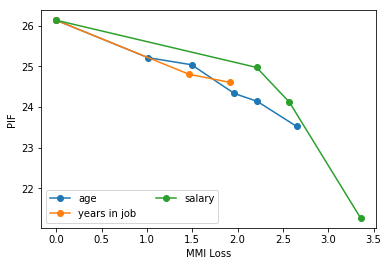

In [112]:
plt.plot(MMIs[:6], PIFs[:6], '-o')
plt.plot(MMIs[6:9], PIFs[6:9], '-o')
plt.plot(MMIs[9:], PIFs[9:], '-o')
plt.xlabel('MMI Loss')
plt.ylabel('PIF')
plt.legend(['age', 'years in job', 'salary'], ncol=2, loc='lower left');

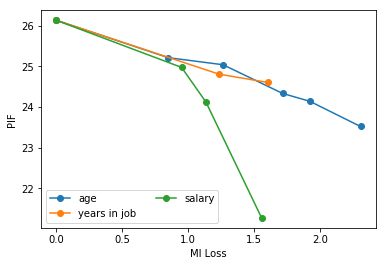

In [115]:
plt.plot(MIs[:6], PIFs[:6], '-o')
plt.plot(MIs[6:9], PIFs[6:9], '-o')
plt.plot(MIs[9:], PIFs[9:], '-o')
plt.xlabel('MI Loss')
plt.ylabel('PIF')
plt.legend(['age', 'years in job', 'salary'], ncol=2, loc='lower left');

In [138]:
inmate_dataset = data2[['ADMITTED_DT', 'DISCHARGED_DT', 'RACE',
       'GENDER', 'INMATE_STATUS_CODE', 'TOP_CHARGE']][:1000]

In [139]:
inmate_dataset.shape

(1000, 6)

In [170]:
inmate_adjustment_targets = ['ADMITTED_DT','DISCHARGED_DT']
inmate_adjusted_dataframes = []

for idx, adj in enumerate(inmate_adjustment_targets):
    for block_count in range(1,20):
        inmate_adjusted_dataframes.append(round_column_quartile(inmate_dataset, adj, block_count))

In [171]:
IMMIs = []
IPIFs = []
IMIs = []
Ibase_info = calculate_mutual_infos(inmate_dataset, inmate_dataset)

for adj in inmate_adjusted_dataframes:
    IPIFs.append(klcalculator.percentile(klcalculator.find_individual_risks(klcalculator.find_risks_for_records(adj.values)), 95))
    adjusted_info = calculate_mutual_infos(inmate_dataset, adj)
    info_loss = Ibase_info - adjusted_info
    IMIs.append(max([info_loss[x,x] for x in range(info_loss.shape[1])]))
    col_tots = max([np.sum(info_loss[:,x]) for x in range(info_loss.shape[1])])
    IMMIs.append(col_tots)

In [172]:
len(IMMIs)

38

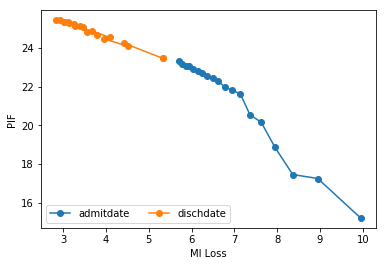

In [173]:
plt.plot(IMIs[:19], IPIFs[:19], '-o')
plt.plot(IMIs[19:], IPIFs[19:], '-o')
plt.xlabel('MI Loss')
plt.ylabel('PIF')
plt.legend(['admitdate', 'dischdate'], ncol=2, loc='lower left');

In [174]:
b = calculate_mutual_infos(inmate_dataset, inmate_dataset)

In [175]:
adjusted_inmate = round_column_quartile(inmate_dataset, 'ADMITTED_DT', 10)
adjusted_inmate = round_column_quartile(adjusted_inmate, 'DISCHARGED_DT', 10)

In [177]:
b_prime = calculate_mutual_infos(inmate_dataset, adjusted_inmate)

In [178]:
display_risks(inmate_dataset.columns, b, maxr=1)

,ADMITTED_DT,DISCHARGED_DT,RACE,GENDER,INMATE_STATUS_CODE,TOP_CHARGE
ADMITTED_DT,9.94827,5.31738,1.07489,0.423945,1.28955,3.86679
DISCHARGED_DT,5.31738,5.33489,0.543258,0.247178,0.488725,1.03655
RACE,1.07489,0.543258,1.07965,0.00437501,0.0146778,0.124848
GENDER,0.423945,0.247178,0.00437501,0.423945,0.00759866,0.0527726
INMATE_STATUS_CODE,1.28955,0.488725,0.0146778,0.00759866,1.2923,0.471821
TOP_CHARGE,3.86679,1.03655,0.124848,0.0527726,0.471821,3.8763


In [181]:
display_risks(adjusted_inmate.columns, b_prime, maxr=1)

,ADMITTED_DT,DISCHARGED_DT,RACE,GENDER,INMATE_STATUS_CODE,TOP_CHARGE
ADMITTED_DT,3.32193,1.7622,1.07489,0.423945,1.28955,3.86679
DISCHARGED_DT,1.63653,1.77095,0.543258,0.247178,0.488725,1.03655
RACE,0.0142186,0.0048607,1.07965,0.00437501,0.0146778,0.124848
GENDER,0.0113718,0.00840512,0.00437501,0.423945,0.00759866,0.0527726
INMATE_STATUS_CODE,0.0670239,0.0858283,0.0146778,0.00759866,1.2923,0.471821
TOP_CHARGE,0.610623,0.45542,0.124848,0.0527726,0.471821,3.8763


In [182]:
Iinfo_loss = b-b_prime

In [183]:
display_risks(adjusted_inmate.columns, Iinfo_loss, maxr=1)

,ADMITTED_DT,DISCHARGED_DT,RACE,GENDER,INMATE_STATUS_CODE,TOP_CHARGE
ADMITTED_DT,6.62635,3.55519,0,0,0,0
DISCHARGED_DT,3.68085,3.56394,0,0,0,0
RACE,1.06067,0.538398,0,0,0,0
GENDER,0.412574,0.238773,0,0,0,0
INMATE_STATUS_CODE,1.22252,0.402897,0,0,0,0
TOP_CHARGE,3.25616,0.581126,0,0,0,0
